In [ ]:
# Runs in Google Colab

In [1]:
import torch
print(torch.__version__)

print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = "cpu"
print(device)

2.3.1+cpu
GPU Available: False
cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Vanilla GAN

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def make_generator_network(
    input_size=20,
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784
):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
      model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
      model.add_module(f'relu_g{i}', nn.LeakyReLU())
      input_size = num_hidden_units

    model.add_module(
        f'fc_g{num_hidden_layers}',
        nn.Linear(input_size, num_output_units)
    )
    model.add_module('tanh_g', nn.Tanh())
    return model


def make_discriminator_network(
    input_size=20,
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1
):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
      model.add_module(
          f'fc_d{i}',
          nn.Linear(input_size, num_hidden_units, bias=False)
      )
      model.add_module(f'relu_d{i}', nn.LeakyReLU())
      model.add_module('dropout', nn.Dropout(p=0.5))
      input_size = num_hidden_units

    model.add_module(
        f'fc_d{num_hidden_layers}',
        nn.Linear(input_size, num_output_units)
    )
    model.add_module('sigmoid', nn.Sigmoid())
    return model

In [5]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)
)
print(gen_model)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size
)
print(disc_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)
Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [6]:
# Scale images from [0, 255] to [-1, 1]

import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True
)

example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14979890.09it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489993.46it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3915350.67it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5453916.05it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [7]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size) * 2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

In [8]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)

mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [11]:
# Training the GAN model

loss_fn = nn.BCELoss()
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6983
Discriminator Losses: Real 0.7479 Fake 0.6885


In [13]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)

mnist_dl = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)
).to(device)
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size
).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [14]:
def d_train(x):
  disc_model.zero_grad()

  # Train with a real batch
  batch_size = x.size(0)
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

# Train with a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return (
      d_loss.data.item(),
      d_proba_real.detach(),
      d_proba_fake.detach()
  )


def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size, 1, device=device)

  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)

  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [15]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0


epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 10


for epoch in range(1, num_epochs+1):
  d_losses, g_losses = [], []
  d_vals_real, d_vals_fake = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_train(x))
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())

  print(
      f'Epoch {epoch:03d} | Avg Losses >>'
      f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
      f' [D-Real: {all_d_real[-1]:.4f}'
      f' D-Fake: {all_d_fake[-1]:.4f}]'
  )
  epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 0.8737/0.9513 [D-Real: 0.7790 D-Fake: 0.4778]
Epoch 002 | Avg Losses >> G/D 0.9028/1.2202 [D-Real: 0.5802 D-Fake: 0.4595]
Epoch 003 | Avg Losses >> G/D 1.0731/1.0767 [D-Real: 0.6337 D-Fake: 0.3902]
Epoch 004 | Avg Losses >> G/D 0.9914/1.1329 [D-Real: 0.6083 D-Fake: 0.3997]
Epoch 005 | Avg Losses >> G/D 0.9717/1.2059 [D-Real: 0.5785 D-Fake: 0.4186]
Epoch 006 | Avg Losses >> G/D 0.9872/1.2024 [D-Real: 0.5839 D-Fake: 0.4182]
Epoch 007 | Avg Losses >> G/D 0.9679/1.1920 [D-Real: 0.5855 D-Fake: 0.4170]
Epoch 008 | Avg Losses >> G/D 0.9818/1.2067 [D-Real: 0.5812 D-Fake: 0.4178]
Epoch 009 | Avg Losses >> G/D 0.9702/1.1843 [D-Real: 0.5904 D-Fake: 0.4119]
Epoch 010 | Avg Losses >> G/D 0.9830/1.2019 [D-Real: 0.5840 D-Fake: 0.4163]


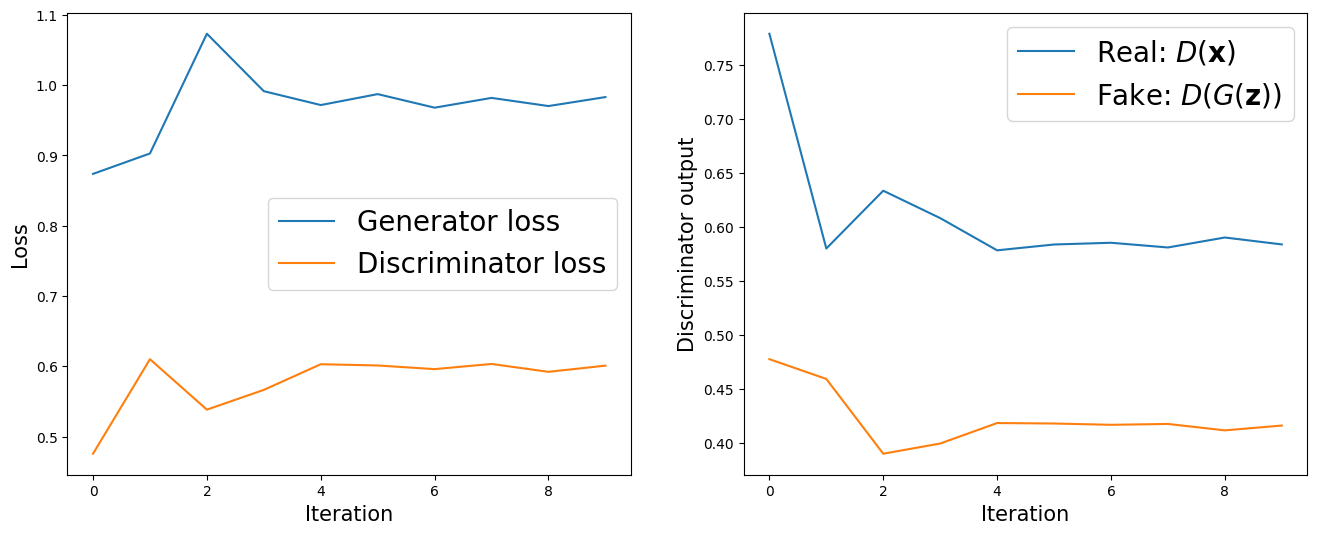

In [17]:
import itertools

fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

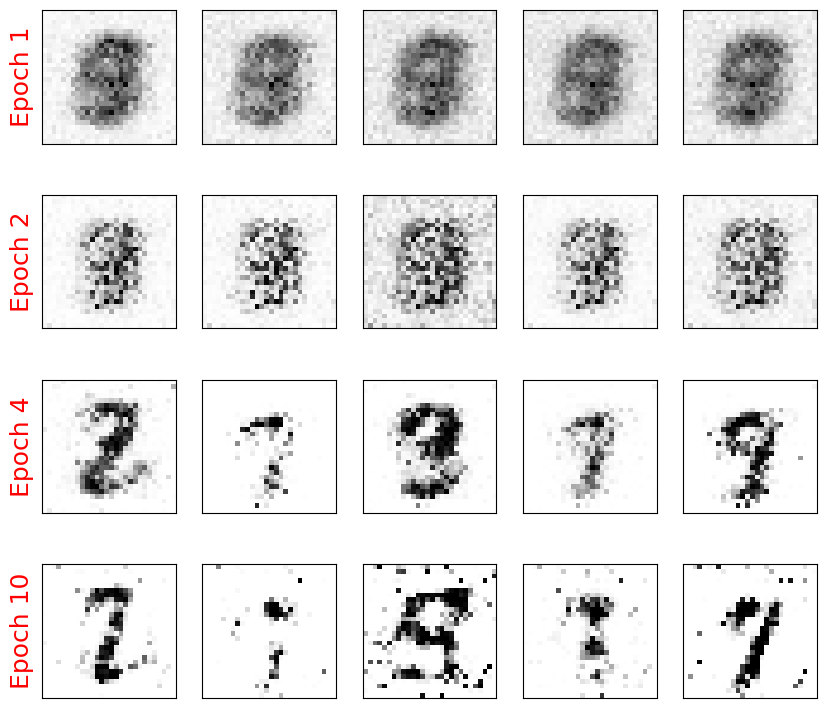

In [19]:
selected_epochs = [1, 2, 4, 10]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, f'Epoch {e}',
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes
      )
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

In [23]:
# Convolutional and Wasserstein GAN

def make_generator_network(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(
          input_size,
          n_filters*4,
          4, 1, 0,
          bias=False
      ),
      nn.BatchNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(
          n_filters*4,
          n_filters*2,
          3, 2, 1,
          bias=False
      ),
      nn.BatchNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(
          n_filters*2,
          n_filters,
          4, 2, 1,
          bias=False
      ),
      nn.BatchNorm2d(n_filters),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(
          n_filters,
          1,
          4, 2, 1,
          bias=False
      ),
      nn.Tanh()
  )
  return model


class Discriminator(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(
            1,
            n_filters,
            4, 2, 1,
            bias=False
            ),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            n_filters,
            n_filters*2,
            4, 2, 1,
            bias=False
        ),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            n_filters*2,
            n_filters*4,
            3, 2, 1,
            bias=False
        ),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            n_filters*4,
            1,
            4, 1, 0,
            bias=False
        ),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1, 1).squeeze(0)

In [24]:
z_size = 100
image_size = (28, 28)
n_filters = 32

In [25]:
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [26]:
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [27]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [30]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1, 1) * 2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1, 1)
  return input_z


def d_train(x):
  disc_model.zero_grad()

  # Train with a real batch
  batch_size = x.size(0)
  x = x.to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train with a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return (
      d_loss.data.item(),
      d_proba_real.detach(),
      d_proba_fake.detach()
  )

In [31]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
epoch_samples = []
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
  gen_model.train()
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_train(x))
  print(
      f'Epoch {epoch:03d} | Avg Losses >>'
      f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
      f'/{torch.FloatTensor(d_losses).mean():.4f}'
  )

  gen_model.eval()
  epoch_samples.append(
      create_samples(
          gen_model, fixed_z
      ).detach().cpu().numpy()
  )

Epoch 001 | Avg Losses >> G/D 2.8131/0.6563
Epoch 002 | Avg Losses >> G/D 3.3812/0.4866
Epoch 003 | Avg Losses >> G/D 3.5207/0.4272
Epoch 004 | Avg Losses >> G/D 3.4380/0.4051
Epoch 005 | Avg Losses >> G/D 3.3782/0.3922
Epoch 006 | Avg Losses >> G/D 3.3235/0.3839
Epoch 007 | Avg Losses >> G/D 3.2721/0.3806
Epoch 008 | Avg Losses >> G/D 3.2365/0.3727
Epoch 009 | Avg Losses >> G/D 3.2109/0.3668
Epoch 010 | Avg Losses >> G/D 3.1921/0.3599


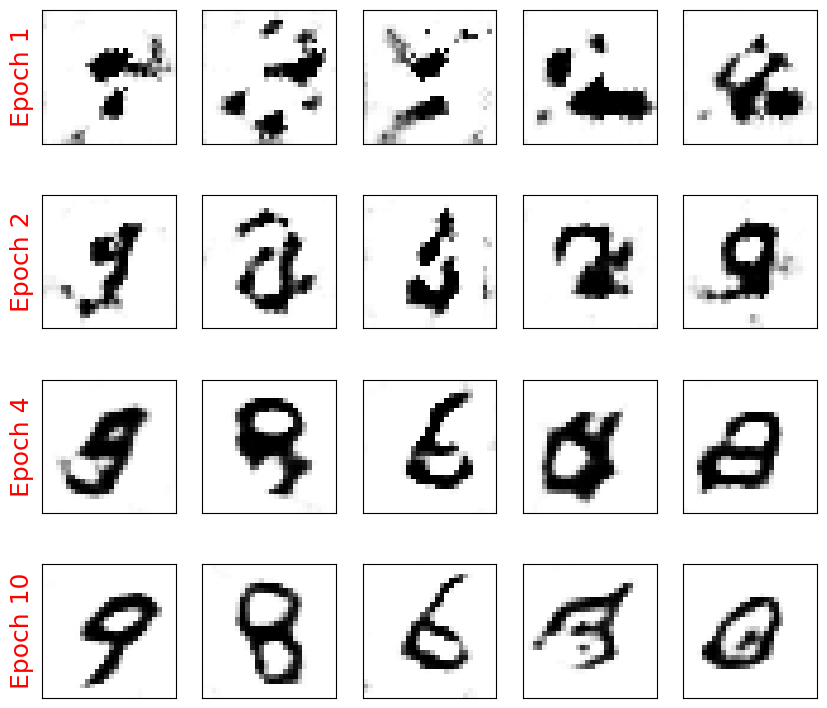

In [33]:
selected_epochs = [1, 2, 4, 10]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, f'Epoch {e}',
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes
      )
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

In [38]:
# WGAN-GP

def make_generator_network_wgan(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(
          input_size,
          n_filters*4,
          4, 1, 0,
          bias=False
      ),
      nn.InstanceNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(
          n_filters*4,
          n_filters*2,
          3, 2, 1,
          bias=False
      ),
      nn.InstanceNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(
          n_filters*2,
          n_filters,
          4, 2, 1,
          bias=False
      ),
      nn.InstanceNorm2d(n_filters),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(
          n_filters,
          1,
          4, 2, 1,
          bias=False
      ),
      nn.Tanh()
  )
  return model


class DiscriminatorWGAN(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(
            1,
            n_filters,
            4, 2, 1,
            bias=False
        ),
        nn.LeakyReLU(0.2),

        nn.Conv2d(
            n_filters,
            n_filters*2,
            4, 2, 1,
            bias=False
        ),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(
            n_filters*2,
            n_filters*4,
            3, 2, 1,
            bias=False
        ),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(
            n_filters*4,
            1,
            4, 1, 0,
            bias=False
        ),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1, 1).squeeze(0)

In [44]:
gen_model = make_generator_network_wgan(
    z_size, n_filters
).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)


from torch.autograd import grad as torch_grad

def gradient_penalty(real_data, generated_data):
  batch_size = real_data.size(0)
  alpha = torch.rand(
      real_data.shape[0],
      1, 1, 1,
      requires_grad=True,
      device=device
  )
  interpolated = alpha * real_data + (1-alpha) * generated_data
  proba_interpolated = disc_model(interpolated)
  gradients = torch_grad(
      outputs=proba_interpolated,
      inputs=interpolated,
      grad_outputs=torch.ones(proba_interpolated.size(), device=device),
      create_graph=True,
      retain_graph=True
  )[0]
  gradients = gradients.view(batch_size, -1)
  gradients_norm = gradients.norm(2, dim=1)
  return lambda_gp * ((gradients_norm-1)**2).mean()


def d_train_wgan(x):
  disc_model.zero_grad()

  batch_size = x.size(0)
  x = x.to(device)


  d_real = disc_model(x)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_generated = disc_model(g_output)
  d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item()


def g_train_wgan(x):
  gen_model.zero_grad()

  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)

  d_generated = disc_model(g_output)
  g_loss = -d_generated.mean()

  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [45]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 10
torch.manual_seed(1)
critic_iterations = 5
for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses, g_losses = [], []
  for i, (x, _) in enumerate(mnist_dl):
    for _ in range(critic_iterations):
      d_loss = d_train_wgan(x)
    d_losses.append(d_loss)
    g_losses.append(g_train_wgan(x))

  print(
      f'Epoch {epoch:03d} | D Loss >>'
      f' {torch.FloatTensor(d_losses).mean():.4f}'
  )
  gen_model.eval()
  epoch_samples_wgan.append(
      create_samples(
        gen_model, fixed_z
      ).detach().cpu().numpy()
  )

Epoch 001 | D Loss >> -0.3296
Epoch 002 | D Loss >> -0.5355
Epoch 003 | D Loss >> -0.5931
Epoch 004 | D Loss >> -0.5993
Epoch 005 | D Loss >> -0.6113
Epoch 006 | D Loss >> -0.5822
Epoch 007 | D Loss >> -0.5581
Epoch 008 | D Loss >> -0.5412
Epoch 009 | D Loss >> -0.5274
Epoch 010 | D Loss >> -0.5072


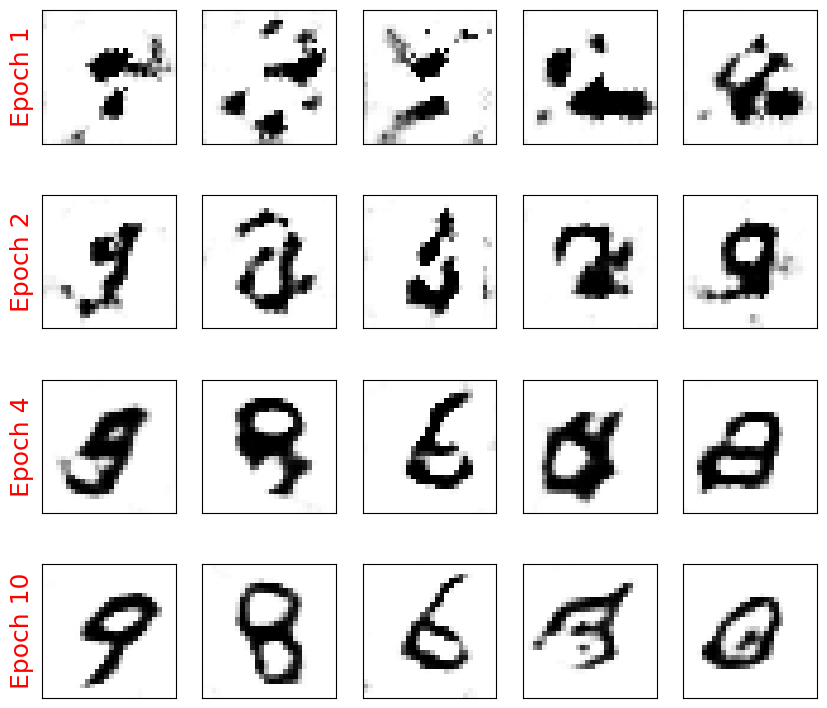

In [46]:
selected_epochs = [1, 2, 4, 10]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, f'Epoch {e}',
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes
      )
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()